In [21]:
import json
from collections import Counter
from augur.utils import json_to_tree
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd

# Figure 2: All segments get mutations during egg-passaging, but sites that repeatedly mutate in different strains are all located in HA

In [22]:
def determine_mut_type(virus, egg_muts, segment):
    """
    Given a list of mutations that occured during egg-passaged, find which are syn, nonsyn or noncoding
    Noncoding would fall outside of the CDS.
    Use difference of nuc muts and nonsyn muts to determine syn
    Look only at point muts (not deletions)
    """
    # all nt muts
    nuc_muts = egg_muts['nuc']
    
    # find which ones occur within CDS 
    
    reference_file = f'../nextstrain_builds/egg-enriched/config/{virus}/{segment}/genemap.gff'
    
    cds_start = 1000
    cds_end = 0
    
    with open(reference_file, 'r') as gff_handle:
        gff_lines = gff_handle.readlines()
        for line in gff_lines:
            if 'gene' in line.split('\t'):
                gene_location = [int(line.split('\t')[3])-1, int(line.split('\t')[4])]
                if gene_location[0]< cds_start:
                    cds_start = gene_location[0]
                if gene_location[0]> cds_end:
                    cds_end = gene_location[1]
                    
    
    num_noncoding = 0
    for m in nuc_muts:
        if int(m[:-1]) not in range(cds_start, cds_end):
            num_noncoding+=1
    
    num_nonsyn = sum([len([x for x in v if x[-1]!='-']) for k,v in egg_muts.items() if k!='nuc'])
    num_syn = len(nuc_muts)-num_nonsyn-num_noncoding
    
    
    return num_syn, num_nonsyn, num_noncoding

In [23]:
def get_syn_nonsyn_count(virus, segment):
    """
    Get the number of mutations that are syn, nonsyn, or noncoding within the segment
    Count the number of strains that have at least one syn of nonsyn mut
    """
    
    curated_mut_file = f"../egg-mutation-analysis/egg-muts-by-strain/{virus}_{segment}_curated-egg-muts.json"
    
    with open(curated_mut_file) as json_handle:
        egg_mut_info = json.load(json_handle)
    
    total_strains = 0
    strains_w_syn = 0
    strains_w_nonsyn = 0
    strains_w_noncoding = 0
    

    for strain, muts in egg_mut_info.items():
        total_strains+=1
        num_syn, num_nonsyn, num_noncoding = determine_mut_type(virus, muts, segment)
        if num_syn!=0:
            strains_w_syn+=1
        if num_nonsyn!=0:
            strains_w_nonsyn+=1
        if num_noncoding !=0:
            strains_w_noncoding+=1


    
    return total_strains, strains_w_syn, strains_w_nonsyn

In [24]:
def plot_syn_nonsyn_per_segment(virus, ax):
    """
    Compare counts of syn and nonsyn between all segments
    """
    
    segments = ['pb1', 'pb2', 'pa', 'ha', 'np', 'na', 'mp', 'ns']
    
    muts_counts_to_plot = []
    

    for s in segments:
        total_strains, strains_w_syn, strains_w_nonsyn = get_syn_nonsyn_count(virus,s)
        percent_w_syn = strains_w_syn/total_strains
        percent_w_nonsyn = strains_w_nonsyn/total_strains
        muts_counts_to_plot.append({'virus':virus, 'segment':s.upper(), 'mut_pct':percent_w_nonsyn, 'mut_type':'Nonsyn'})
        muts_counts_to_plot.append({'virus':virus, 'segment':s.upper(), 'mut_pct':percent_w_syn, 'mut_type':'Syn'})

    to_plot_df = pd.DataFrame(muts_counts_to_plot)
    sns.barplot(data=to_plot_df, x='segment', y='mut_pct', hue='mut_type', palette=cmap[virus], ax=ax)

    
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x',labelsize=14, labelrotation=90)
    ax.tick_params(axis='y',labelsize=10)

    # only put legend on far right
    if virus=='yam':
        ax.legend(title='', bbox_to_anchor=(1.2,1.1), fontsize=12)
    else:
        ax.get_legend().remove()
    
    # put y-axis label on far left
    if virus=='h3n2':
        ax.set_ylabel('Proportion of egg-passaged\nstrains with a mutation', fontsize=14)
    # turn y-axis ticks off for all viruses besides h3n2 since they all share y-axis
    else:
        ax.yaxis.set_visible(False) 
        ax.spines['left'].set_color('white')
    
    # put virus name as title for whole column
    ax.set_title(pretty_virus_names[virus], fontsize=18, pad=20)
    
    # add sub-figure label
    if virus =='h3n2':
        ax.text(-0.3, 1.2, 'A', fontsize=28, transform=ax.transAxes)
        
    
    sns.despine()
    
    return ax
            

In [25]:
virus_cmap = {'yam': '#fbba0a', 'vic': '#FF4500', 'h3n2': '#6C3BAA', 'h1n1pdm': '#45b6fe'}

cmap = {'yam': {'Nonsyn': '#fbba0a', 'Syn': '#fde39d'}, 
        'vic' :{'Nonsyn': '#FF4500', 'Syn':'#ffa27f'},
        'h3n2':{'Nonsyn':'#6C3BAA', 'Syn':'#a986d5'},
        'h1n1pdm': {'Nonsyn': '#45b6fe', 'Syn': '#a2dafe'}}

pretty_virus_names = {'h3n2': 'H3N2', 'h1n1pdm': 'H1N1pdm', 'vic': 'Vic', 'yam': 'Yam'}

In [26]:
def plot_nonsyn_mut_pos_in_segment(virus, segment, count_or_prop, ax):
    """
    For the given virus and segment, plot the number of nonsyn mutaitons 
    that occurred during egg-passaging at each position along the coding region of the segment
    """
    
    # get total length of coding region
    reference_file = f'../nextstrain_builds/egg-enriched/config/{virus}/{segment}/genemap.gff'
    
    cds_start = 1000
    cds_end = 0
    
    with open(reference_file, 'r') as gff_handle:
        gff_lines = gff_handle.readlines()
        for line in gff_lines:
            if 'gene' in line.split('\t'):
                gene_location = [int(line.split('\t')[3])-1, int(line.split('\t')[4])]
                if gene_location[0]< cds_start:
                    cds_start = gene_location[0]
                if gene_location[1]> cds_end:
                    cds_end = gene_location[1]
                gene_name = line.split('\t')[8].strip('gene_name=')
                # ha is the only one with multiple genes/subunits labeled
                # nonsyn muts are labeled according to their position within each subunit, 
                # so will need to adjust this for the segment-long plot
                if 'SigPep' in gene_name:
                    sigpep_len_aa = int((gene_location[1]-gene_location[0])/3)
                elif 'HA1' in gene_name:
                    ha1_len_aa = int((gene_location[1]-gene_location[0])/3)
                    
    length_of_cds = int((cds_end-cds_start)/3)

    # read in the mutations each egg-passaged strain has
    curated_mut_file = f"../egg-mutation-analysis/egg-muts-by-strain/{virus}_{segment}_curated-egg-muts.json"
    
    with open(curated_mut_file) as json_handle:
        egg_mut_info = json.load(json_handle)
        
    # count the number of strains with a nonsyn mutation at each position in the gene
    # 1-based numbering for genes
    nonsyn_muts_per_pos = {x+1:0 for x in range(length_of_cds)}
    
    total_num_strains = 0
    for strain, muts in egg_mut_info.items():
        total_num_strains+=1
        for g, l in muts.items():
            # get all nonsyn muts
            if g!='nuc':
                for m in l:
                    mut_pos = int(m[:-1])

                    # have to adjust the positions for ha muts because of different subunits
                    if segment=='ha':
                        if g=='HA1':
                            mut_pos = mut_pos + sigpep_len_aa
                        elif g == 'HA2':
                            mut_pos = mut_pos + sigpep_len_aa + ha1_len_aa

                    nonsyn_muts_per_pos[mut_pos]+=1
    
    codons = [x+1 for x in range(length_of_cds)]
    mut_counts = [nonsyn_muts_per_pos[x] for x in codons]
    mut_pcts = [x/total_num_strains for x in mut_counts]
    if count_or_prop=='count':
        ax.plot(codons, mut_counts, color=virus_cmap[virus])
    elif count_or_prop == 'prop':
        ax.plot(codons, mut_pcts, color=virus_cmap[virus])

    # probably just label the top of the y axis
    if virus=='h3n2' and segment=='ha':
        ax.tick_params(axis='y',labelsize=10)
        
    else:
        ax.yaxis.set_visible(False) 
        ax.spines['left'].set_color('white')
    
    
    # don't need position label
#     ax.get_xaxis().set_ticks([])
    ax.xaxis.set_visible(False) 
    ax.spines['bottom'].set_color('white')
    
    if virus=='h3n2':
        if segment == 'ha':
            if count_or_prop=='count':
                ax.set_ylabel('Number of egg-passaged strains\nwith an amino acid change', fontsize=14)
            elif count_or_prop == 'prop':
                ax.set_ylabel('Proportion of egg-passaged strains\nwith an amino acid change', fontsize=14)
        # label the sub-figure panel
        if segment == 'pb1':
            ax.text(-0.3, 1.0, 'B', fontsize=28, transform=ax.transAxes)
    # label the segment for whole row     
    if virus == 'yam':
        ax.text(1.0, 0.2, segment.upper(), fontsize=18, transform=ax.transAxes)
        
            
    
    sns.despine()
    
    return ax

In [27]:
def plot_segment_coordinates(ax):
    """
    Just plot the x-coordinates of the segment once, to keep everything less crowded
    """
    #make y-axis invisible
    ax.yaxis.set_visible(False) 
    ax.spines['left'].set_color('white')
    
    ax.set_xlabel('Amino acid position along segment', fontsize=14)
    ax.xaxis.set_label_coords(0.7, -3.5)
    
    sns.despine()
    
    return ax

In [28]:
def plot_fig2(count_or_prop, filename=None):
    """
    Plot the number of mutations at each position along the coding region of the segment
    for all segments for this virus
    """
    
    viruses = ['h3n2', 'h1n1pdm', 'vic', 'yam']
    segments = ['pb1', 'pb2', 'pa', 'ha', 'np', 'na', 'mp', 'ns']

    #plot styling
    sns.set_style("white")
    plt.rcParams['figure.dpi']= 300
    plt.rcParams['font.family'] = 'Arial'
    
    fig = plt.figure(figsize=(14, 12))
    gs = GridSpec(len(segments) + 3, len(viruses), figure=fig, 
                  height_ratios=[3, 1, 0.75, 0.75, 0.75, 3, 0.75, 0.75, 0.75, 0.75, .1]) 
    
    # store the gridspec axes when they are made so I can access them later (for axis sharing)
    axs = {}
    
    for j, virus in enumerate(viruses):
        # plot number of mutations per segment on first row
        ax = fig.add_subplot(gs[0, j])
        plot_syn_nonsyn_per_segment(virus, ax)
        axs[0,j] = ax
        

    
    for i, segment in enumerate(segments):
        for j, virus in enumerate(viruses):
            ax = fig.add_subplot(gs[i+2, j])
            plot_nonsyn_mut_pos_in_segment(virus, segment, count_or_prop, ax)
            axs[i+2,j] = ax
    
    
    # make muts per segment plots share axes
    # and make the nonsyn per site plots share axes
    for i, segment in enumerate(segments):
        for j, virus in enumerate(viruses):
            # share Y with h3n2, which has the most muts
            axRow1 = axs[0,j]
            axRow1.sharey(axs[0,0])
            
            axOther = axs[i+2, j]
            # share X with pb2, the longest segment
            axOther.sharex(axs[3,j])
            # share Y with HA, the segment with most nonsyn muts
            axOther.sharey(axs[5,0])
            
    # annotate x-axis to diagram segment coordinates on final plot
    axArrow = fig.add_subplot(gs[10, 0])
    plot_segment_coordinates(axArrow)
    # annotating the left-most column, so share x with h3n2 pb2
    axArrow.sharex(axs[3, 0])
    
 
    plt.subplots_adjust(wspace=0.1, hspace=0.03)
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight', transparent=False, facecolor='white')

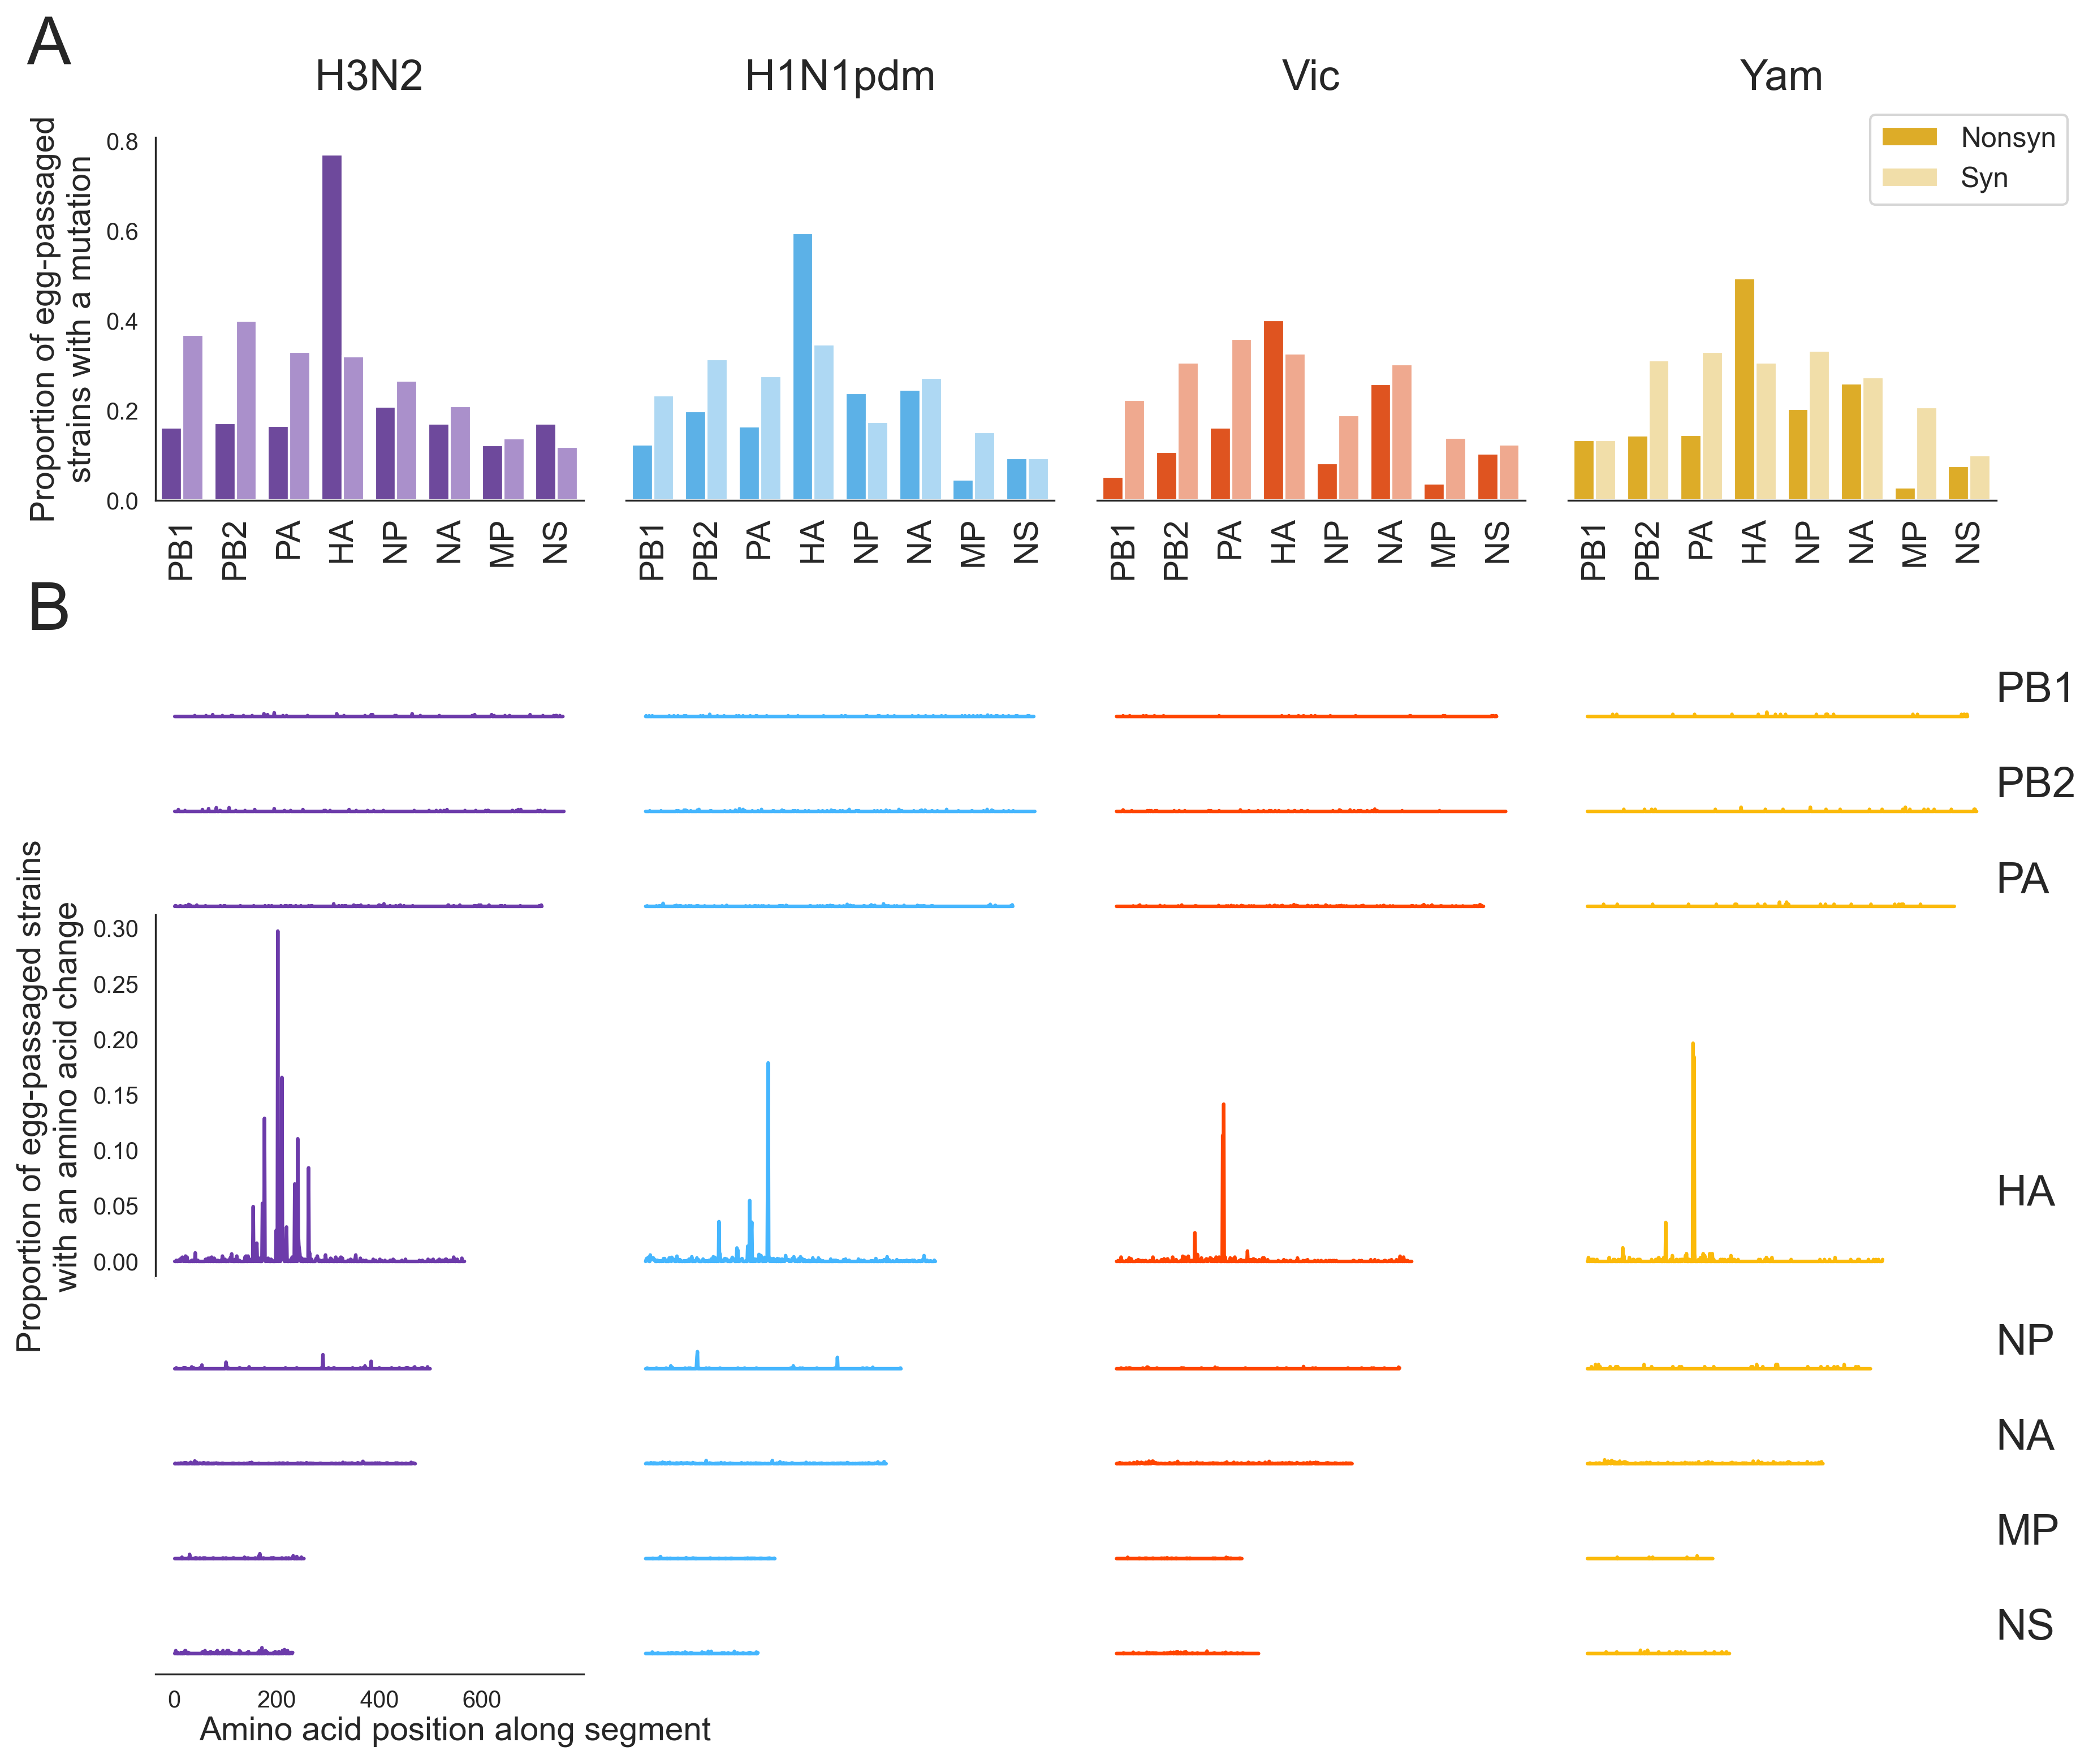

In [10]:
plot_fig2(count_or_prop='prop', filename = 'Figure2/Figure2.png')

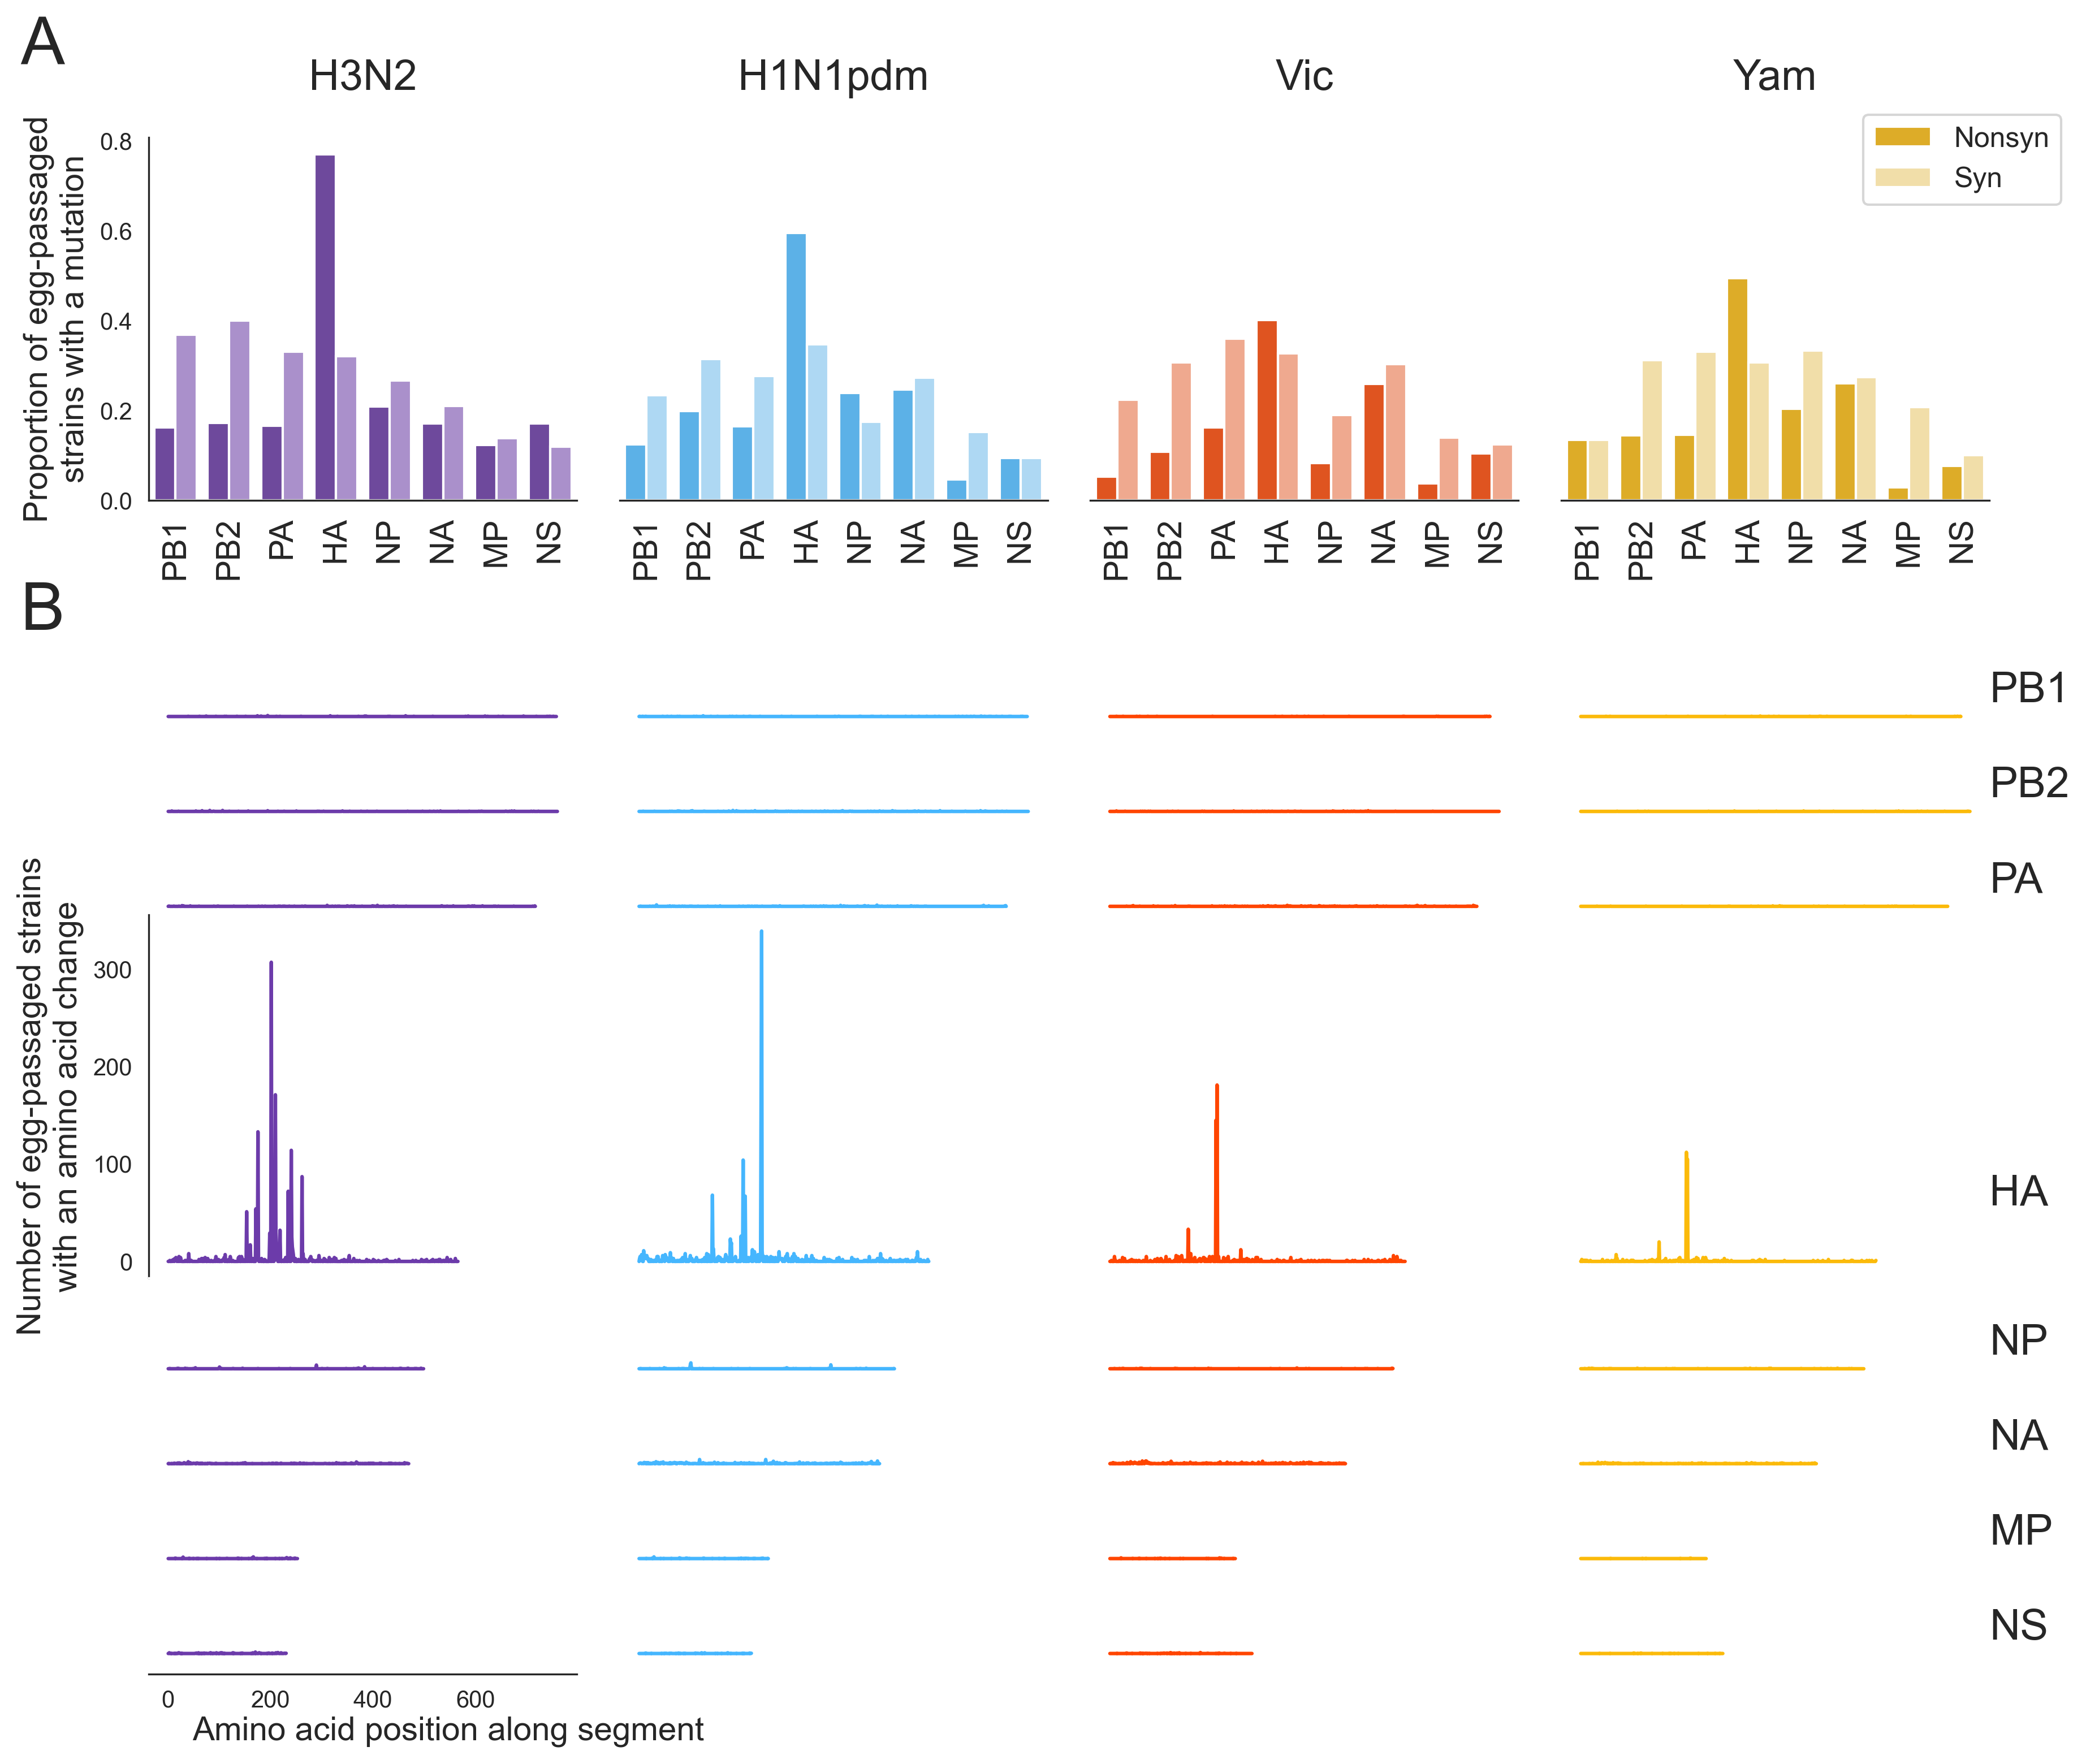

In [11]:
plot_fig2(count_or_prop='count')

## Unused code below

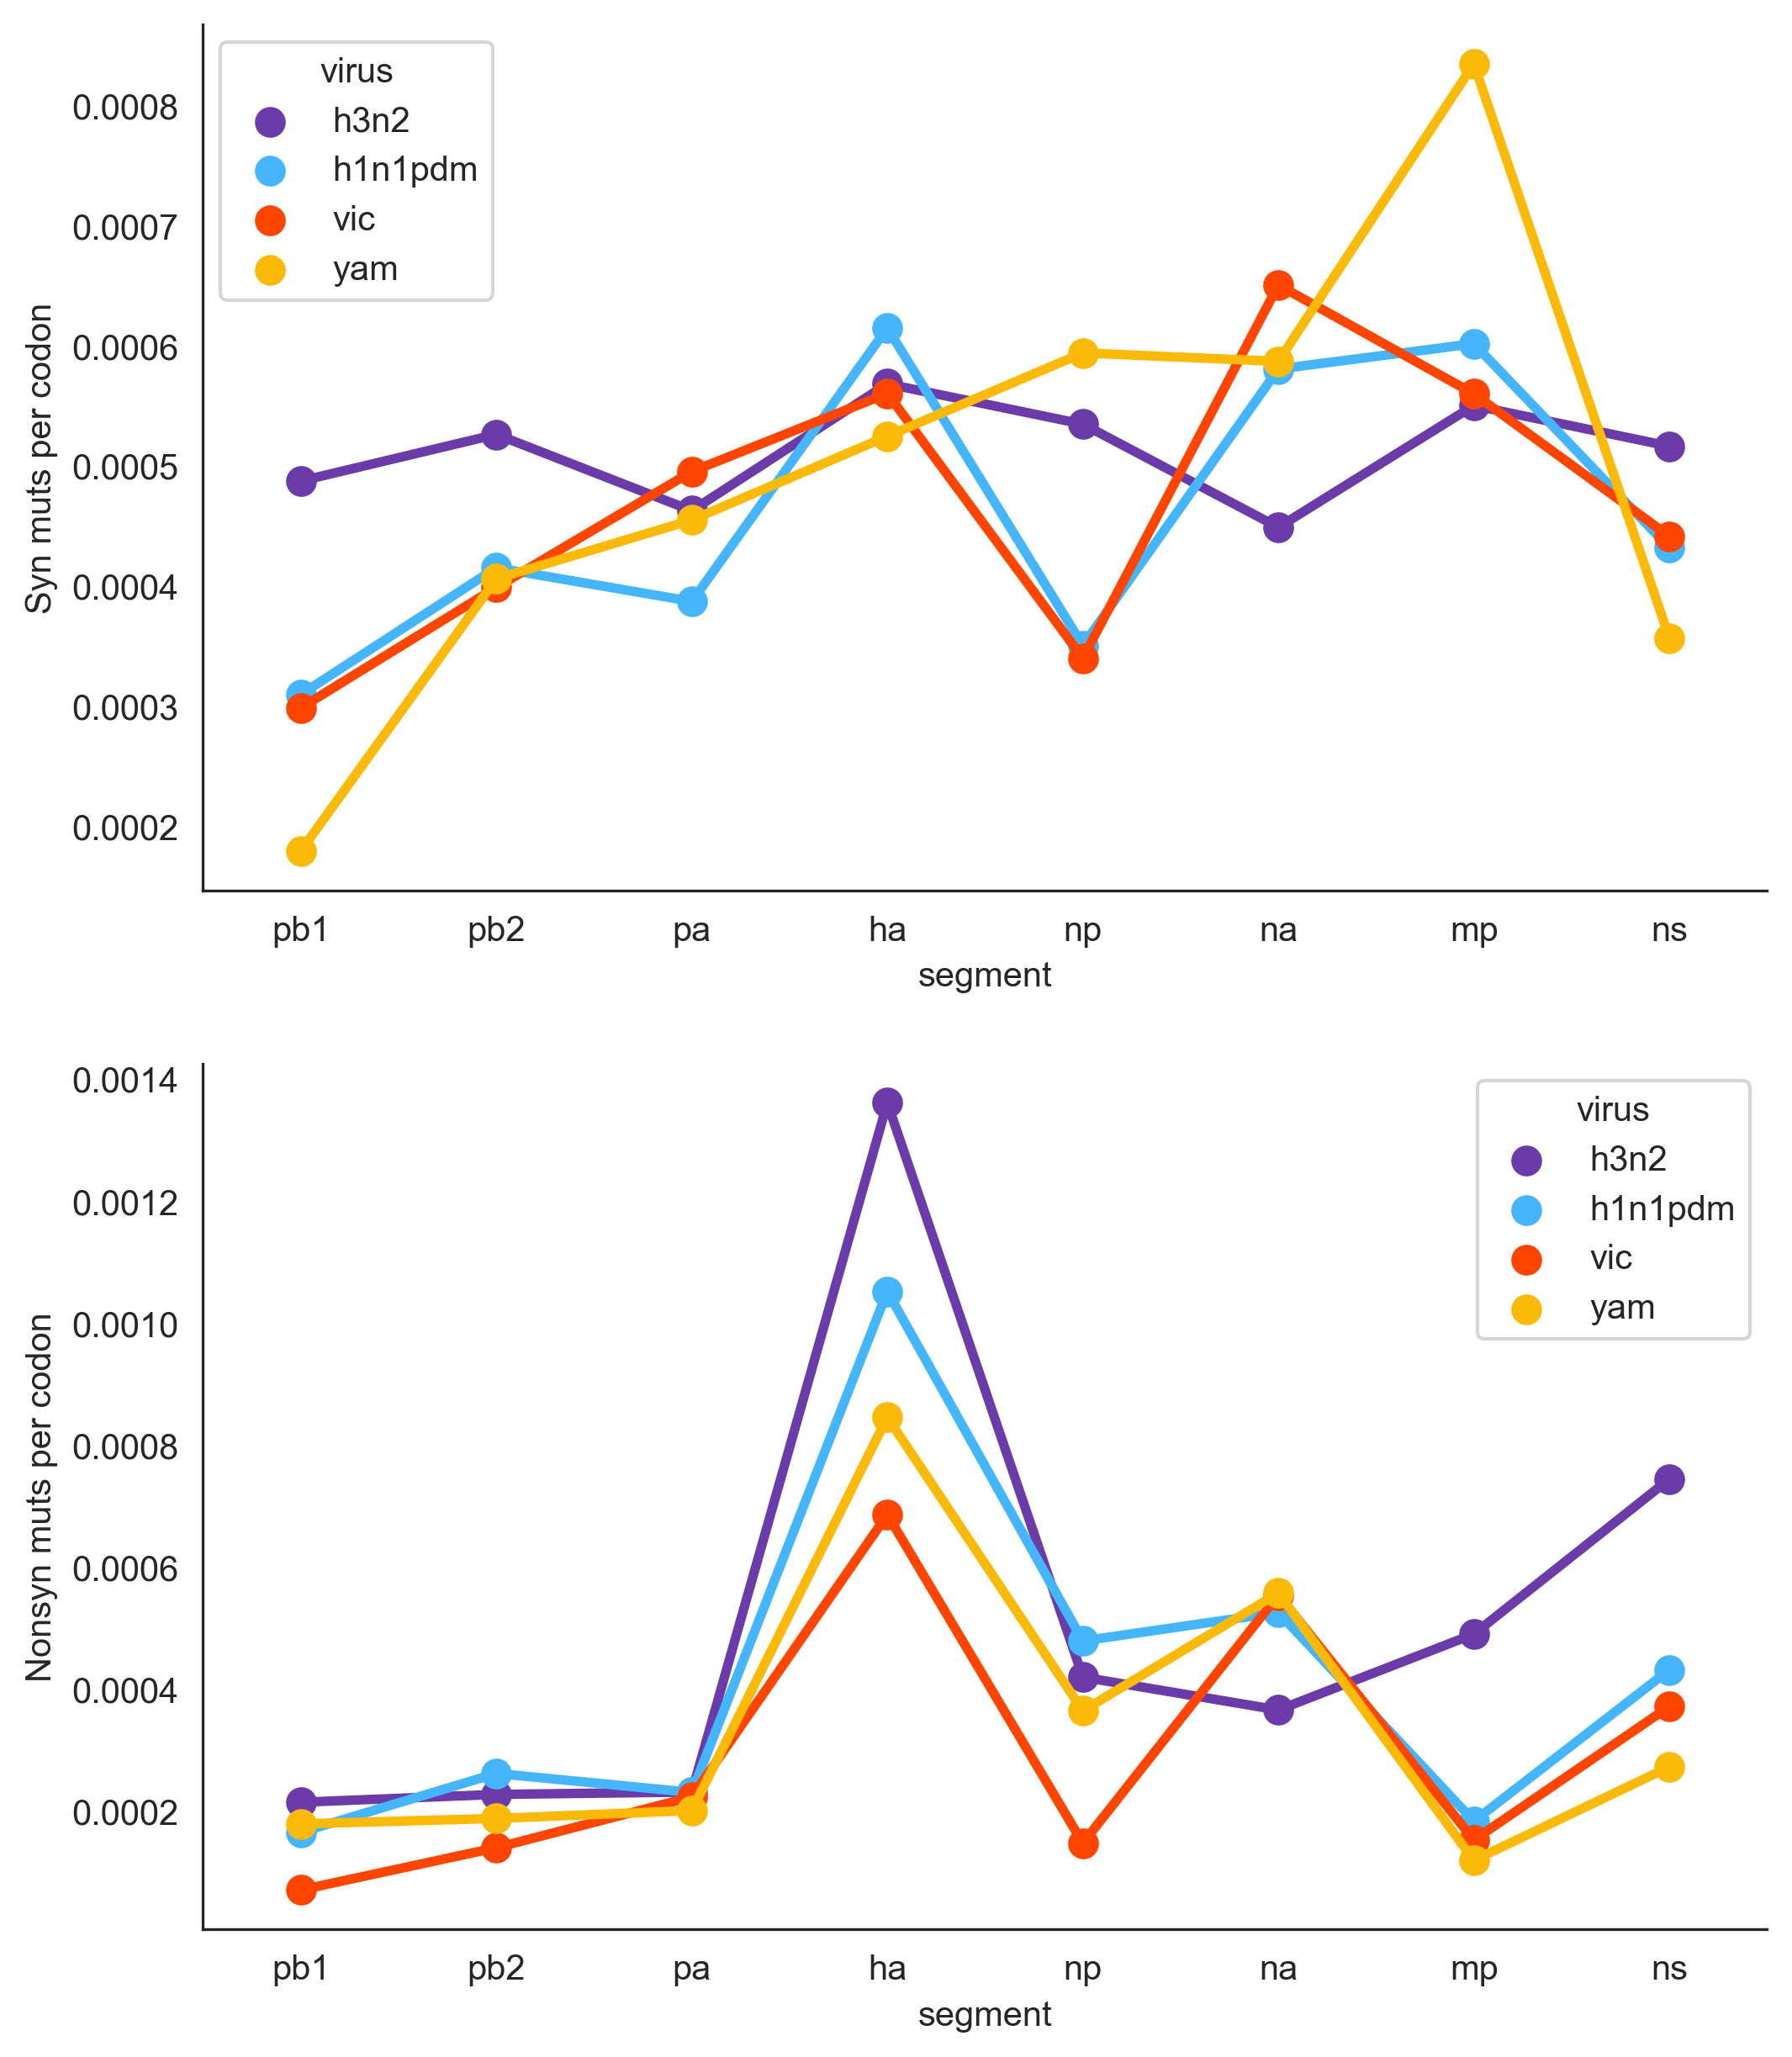

In [20]:
# get proportion of strains mutated, normalized by length of segment

viruses = ['h3n2', 'h1n1pdm', 'vic', 'yam']
segments = ['pb1', 'pb2', 'pa', 'ha', 'np', 'na', 'mp', 'ns']

pct_strains_normalized_by_length = []


for virus in viruses:
    for segment in segments:
        # get length of segment
        # get total length of coding region
        reference_file = f'../nextstrain_builds/egg-enriched/config/{virus}/{segment}/genemap.gff'

        cds_start = 1000
        cds_end = 0
    
        with open(reference_file, 'r') as gff_handle:
            gff_lines = gff_handle.readlines()
            for line in gff_lines:
                if 'gene' in line.split('\t'):
                    gene_location = [int(line.split('\t')[3])-1, int(line.split('\t')[4])]
                    if gene_location[0]< cds_start:
                        cds_start = gene_location[0]
                    if gene_location[1]> cds_end:
                        cds_end = gene_location[1]
                    gene_name = line.split('\t')[8].strip('gene_name=')
                    # ha is the only one with multiple genes/subunits labeled
                    # nonsyn muts are labeled according to their position within each subunit, 
                    # so will need to adjust this for the segment-long plot
                    if 'SigPep' in gene_name:
                        sigpep_len_aa = int((gene_location[1]-gene_location[0])/3)
                    elif 'HA1' in gene_name:
                        ha1_len_aa = int((gene_location[1]-gene_location[0])/3)

        length_of_cds = int((cds_end-cds_start)/3)


        total_strains, strains_w_syn, strains_w_nonsyn = get_syn_nonsyn_count(virus,segment)
        percent_w_syn = strains_w_syn/total_strains
        percent_w_nonsyn = strains_w_nonsyn/total_strains

        pct_strains_normalized_by_length.append({'virus': virus, 'segment':segment,
                                                 'mut_type': 'Syn', 
                                                 'mut_pct': percent_w_syn, 
                                                 'mut_pct_by_len': percent_w_syn/length_of_cds})
        pct_strains_normalized_by_length.append({'virus': virus, 'segment':segment,
                                                 'mut_type': 'Nonsyn', 
                                                 'mut_pct': percent_w_nonsyn, 
                                                 'mut_pct_by_len': percent_w_nonsyn/length_of_cds})
    
df = pd.DataFrame(pct_strains_normalized_by_length)


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10))
sns.pointplot(x='segment', y='mut_pct_by_len', hue='virus', palette=virus_cmap, s=100, 
              data=df[df['mut_type']=='Syn'], ax=ax1)
ax1.set_ylabel('Syn muts per codon')
sns.pointplot(x='segment', y='mut_pct_by_len', hue='virus', palette=virus_cmap, s=100, 
              data=df[df['mut_type']=='Nonsyn'], ax=ax2)
ax2.set_ylabel('Nonsyn muts per codon')

sns.despine()